# Preprocessing

### Importing libraries and datasets

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cleaning_functions as cf 

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score


In [2]:
combined_file_path = '../data/cleaned/winequality_combined_cleaned.csv' 
red_file_path = '../data/cleaned/winequality_red_cleaned.csv'
white_file_path = '../data/cleaned/winequality_white_cleaned.csv'
combined_df = pd.read_csv(combined_file_path)
red_df = pd.read_csv(red_file_path, index_col=0)
white_df = pd.read_csv(white_file_path, index_col=0)

In [3]:
def linear_regression(X_train, X_test, y_train, y_test):
    # Linear regression
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)
    print(f'model coefficients:\n {model.coef_}\n')
    print(f'model intercept:\n {model.intercept_}\n')
    
    # Applying model to X test
    y_pred = model.predict(X_test)
    
    # Ensure y_test is in the correct format (pandas Series or 1D numpy array)
    if isinstance(y_test, pd.Series):
        y_test_reset = y_test.reset_index(drop=True)
    else:
        y_test_reset = y_test  # Assuming y_test is already a numpy array
    
    # Creating combined table with y_test and y_pred
    # Check if y_test_reset is a pandas Series and convert y_pred to a similar type
    if isinstance(y_test_reset, pd.Series):
        y_pred_series = pd.Series(y_pred, index=y_test_reset.index, name='y_pred')
        residuals_df = pd.concat([y_test_reset, y_pred_series], axis=1)
    else:
        # If inputs are numpy arrays, stack them horizontally
        residuals_df = np.column_stack((y_test_reset, y_pred))
        # Convert to DataFrame for easier manipulation later on
        residuals_df = pd.DataFrame(residuals_df, columns=["y_test", "y_pred"])
    
    # Calculating residuals
    residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]
    print(f'Residuals:\n {residuals_df}\n')

    # Root mean squared error
    rmse = mse(y_test_reset, residuals_df["y_pred"], squared=False)
    print(f'Root mean squared error: {rmse} \n')

    # R^2
    r2 = r2_score(y_test_reset, residuals_df["y_pred"])
    print(f'R2: {r2} \n')

    # Calculating adjusted R^2
    n = X_train.shape[0]  # Number of observations in the training set
    p = X_train.shape[1]  # Number of features used for training
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f'Adjusted R2: {adjusted_r2} \n')

    return model.coef_




## Correlations

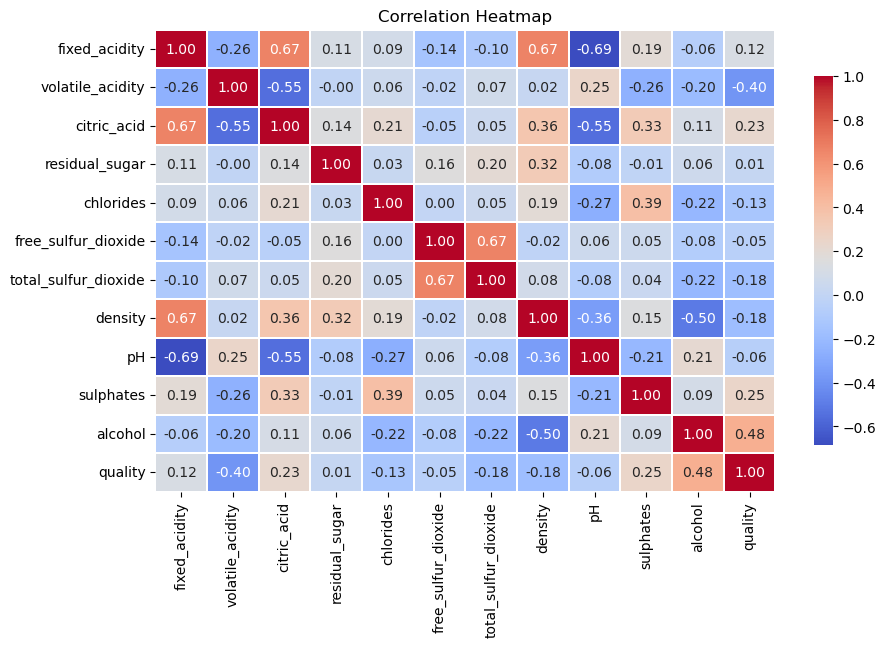

In [4]:
#Red_wine
corr_matrix_red = red_df.corr()
plt.figure(figsize=(10, 6)) 
sns.heatmap(corr_matrix_red, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.05, cbar_kws={'shrink': .8})
plt.title('Correlation Heatmap')  
plt.show()


## IQR Method to handle Outliers

In [5]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.1)
    quartile3 = dataframe[variable].quantile(0.9)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit,2)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,2)
    


In [6]:
red_df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [7]:
columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'sulphates']# only columns identified as having outliers


In [8]:
for col in columns:
    replace_with_thresholds(red_df, col)

In [9]:
red_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1354,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1355,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1356,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1357,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Distributions

<Figure size 1500x1500 with 0 Axes>

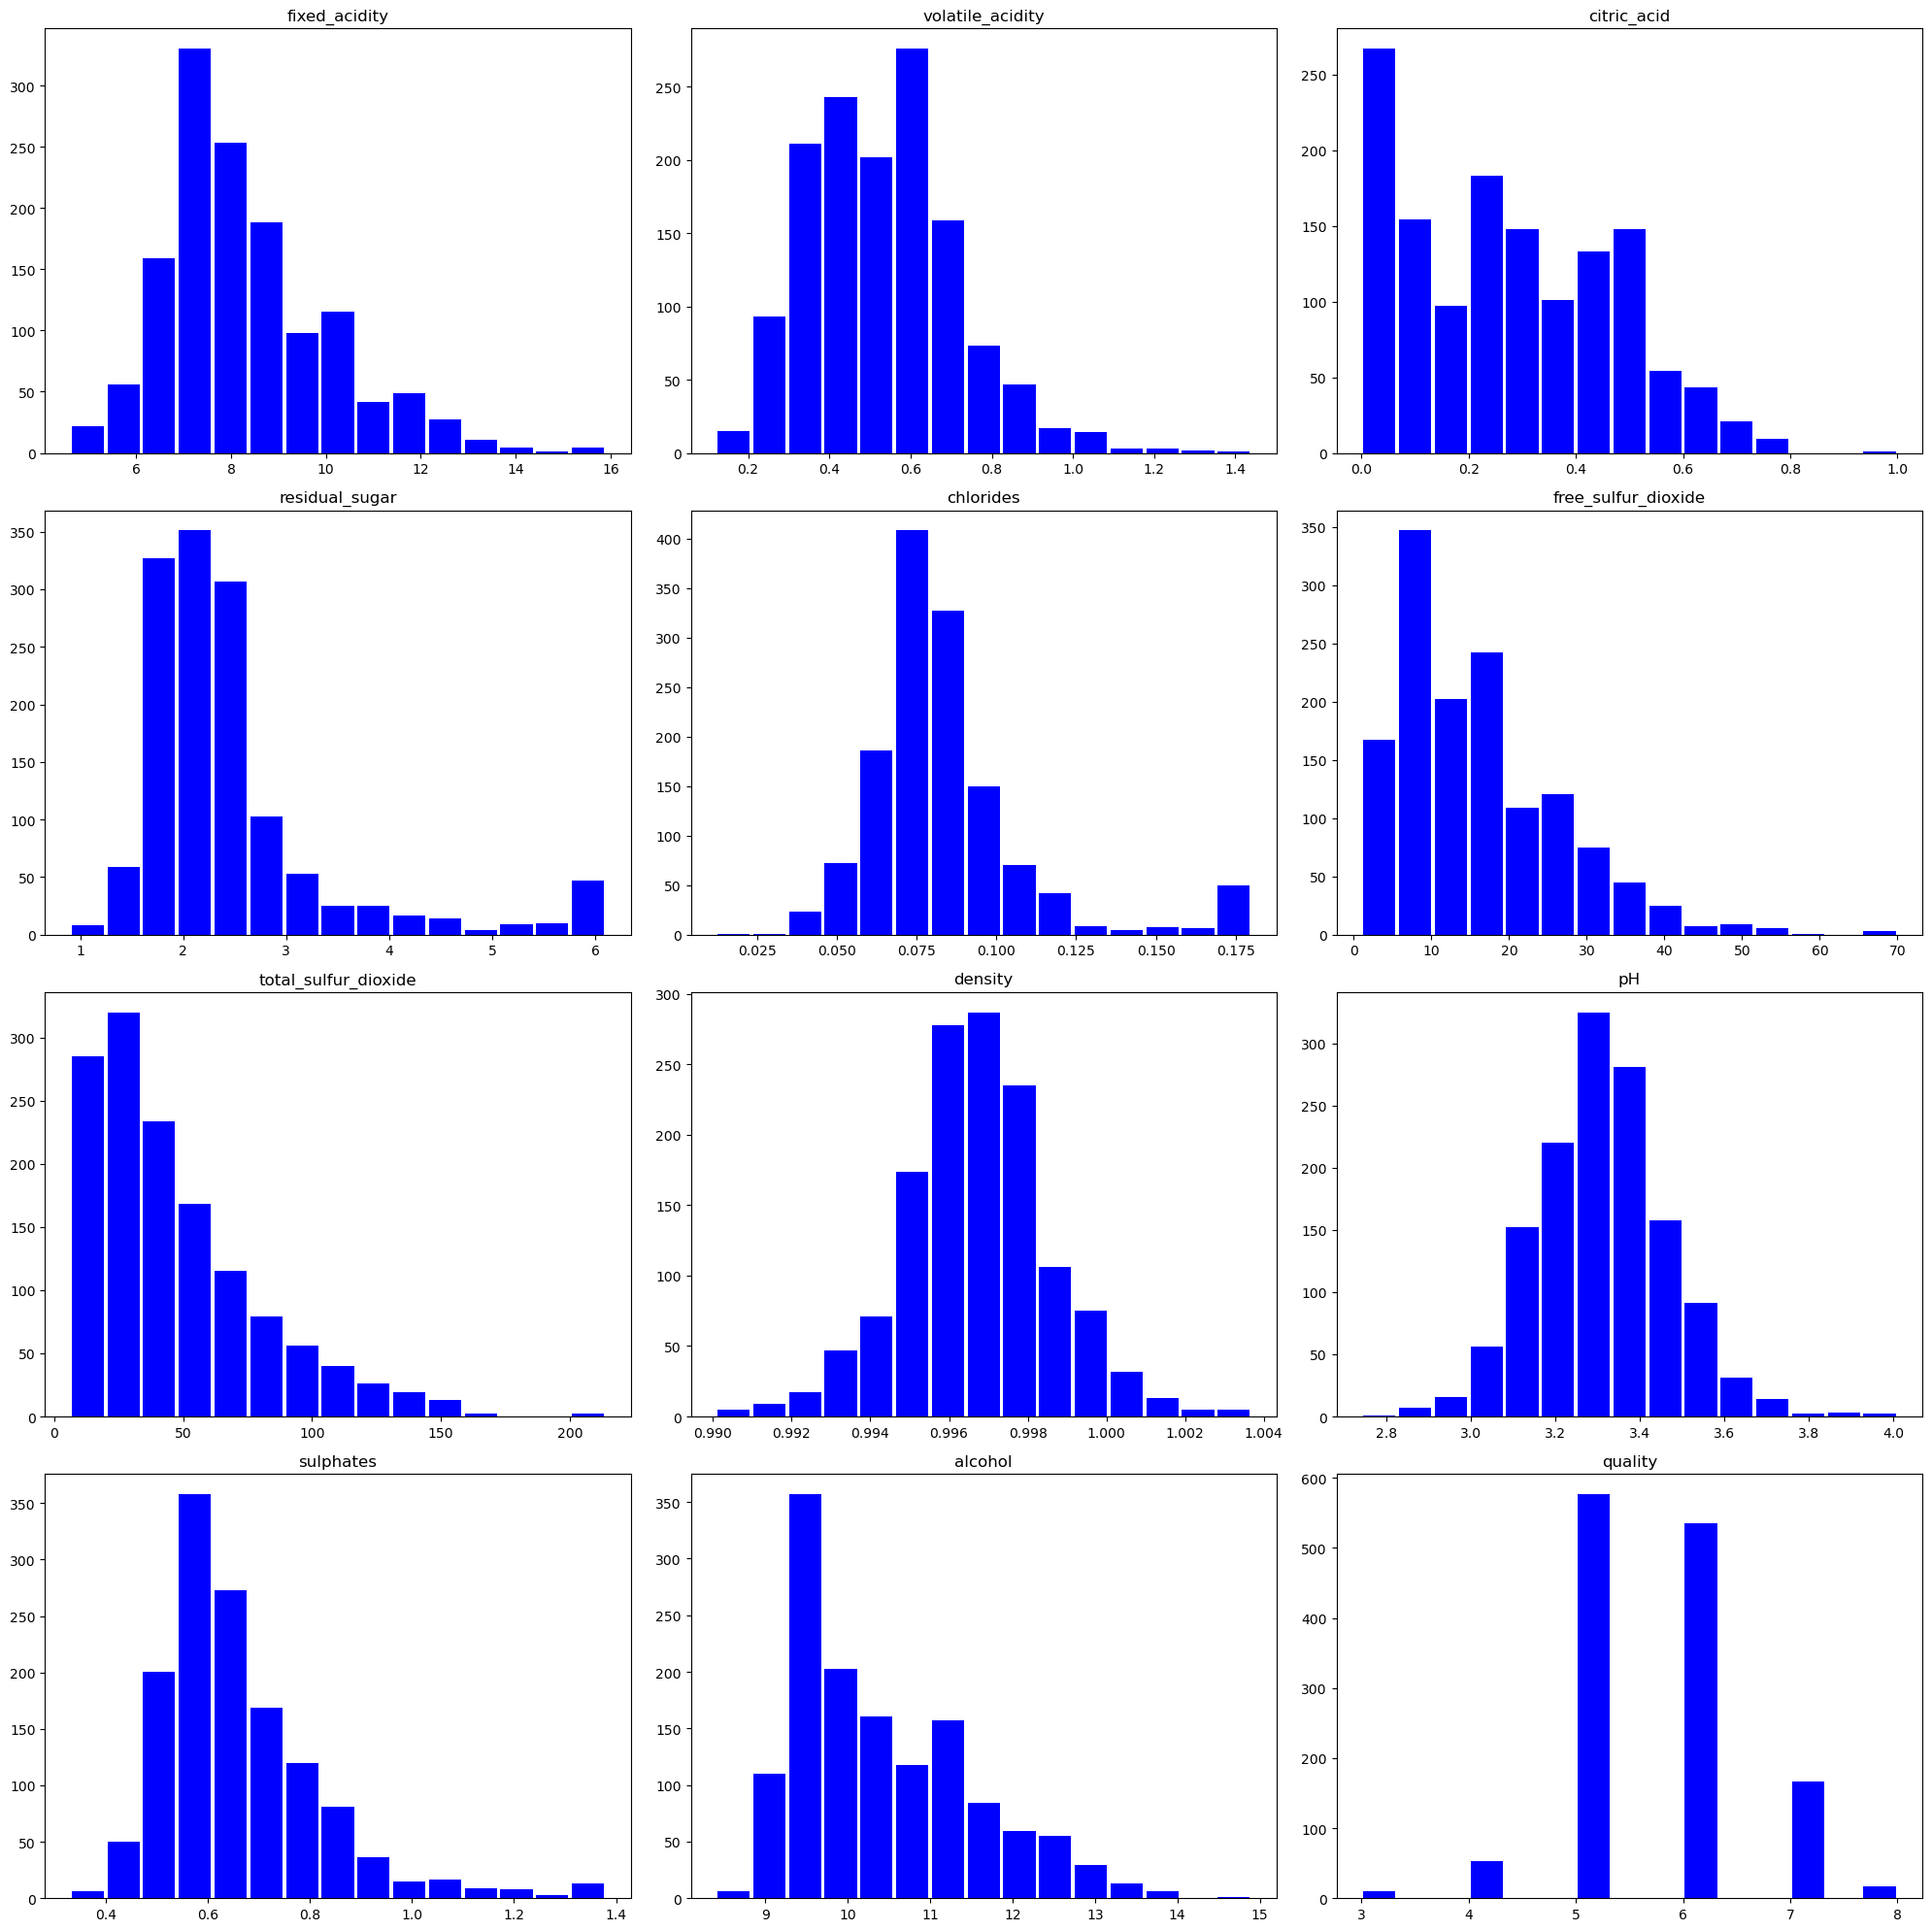

In [10]:
plt.figure(figsize=(15, 15))
red_df.hist(bins=15, grid=False, figsize=(20, 20), color='blue', zorder=2, rwidth=0.9)
plt.tight_layout()
plt.rcParams.update({'font.size': 16})
plt.show()

### Splitting data into X and y

In [11]:
#define X and Y
X = red_df.drop(['quality'], axis=1)
#X = pd.DataFrame(red_df[['citric_acid', 'total_sulfur_dioxide', 'density', 'pH', 'residual_sugar', 'chlorides', 'sulphates', 'alcohol']])
y = pd.DataFrame(red_df["quality"])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

## Applying Scalers and Transforms

### PowerTransformer on X

In [12]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(X_train)
X_train_p = pd.DataFrame(pt.transform(X_train))
X_test_p= pd.DataFrame(pt.transform(X_test))


### PowerTransformer on y

In [13]:
pt_y = PowerTransformer(method='yeo-johnson')
pt_y.fit(y_train)
y_train_p = pt_y.transform(y_train)
y_test_p = pt_y.transform(y_test)


### MinMax Scaler on X

In [14]:
scaler_mm_x = MinMaxScaler()
scaler_mm_x.fit(X_train)
X_train_mm = scaler_mm_x.transform(X_train)
X_test_mm = scaler_mm_x.transform(X_test)

### MinMax Scaler on y

In [15]:
scaler_mm_y = MinMaxScaler()
scaler_mm_y.fit(y_train)
y_train_mm = scaler_mm_y.transform(y_train)
y_test_mm = scaler_mm_y.transform(y_test)

### Standard Scaler on X

In [16]:
scaler_s_x = StandardScaler()
scaler_s_x.fit(X_train)
X_train_s = scaler_s_x.transform(X_train)
X_test_s = scaler_s_x.transform(X_test)

### Standard Scaler on y

In [17]:
scaler_s_y = StandardScaler()
scaler_s_y.fit(y_train)
y_train_s = scaler_s_y.transform(y_train)
y_test_s = scaler_s_y.transform(y_test)

## Linear Regression Model 

In [18]:
coefficients = linear_regression(X_train_p, X_test_p, y_train_p, y_test_p)

model coefficients:
 [[ 0.01426473 -0.20086613 -0.06514387  0.03745411 -0.11396779  0.06590765
  -0.10857112 -0.02949609 -0.13422778  0.24039769  0.33331941]]

model intercept:
 [1.09005003e-12]

Residuals:
        y_test    y_pred  residual
0   -0.755172 -0.539158 -0.216014
1    0.471986  0.378592  0.093394
2    1.613475  1.043597  0.569878
3   -0.755172 -0.861828  0.106656
4   -2.090612 -0.407896 -1.682717
..        ...       ...       ...
335 -0.755172 -0.002598 -0.752574
336  0.471986  0.362823  0.109163
337  0.471986  0.263429  0.208557
338  1.613475  0.966116  0.647359
339  0.471986  0.782774 -0.310788

[340 rows x 3 columns]

Root mean squared error: 0.7910127253152286 

R2: 0.3832654035008186 

Adjusted R2: 0.3765284813940748 



In [21]:
# Linear regression
lm = LinearRegression()
model = lm.fit(X_train_p, y_train_p)
print(f'model coefficients:\n {model.coef_}\n')
print(f'model intercept:\n {model.intercept_}\n')

# Applying model to X test
y_pred = model.predict(X_test_p)
y_pred = pd.DataFrame(pt_y.inverse_transform(y_pred)) # inversing y

y_pred = y_pred.rename(columns = {0:"y_pred"})

y_test = y_test.reset_index(drop=True)
y_test = y_test.rename(columns = {"quality":"y_test"})

residuals_df = pd.concat([y_test,y_pred], axis = 1)
residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]
residuals_df

# Root mean squared error
rmse = mse(y_test, residuals_df["y_pred"], squared=False)
print(f'Root mean squared error: {rmse} \n')

# R^2
r2 = r2_score(y_test, residuals_df["y_pred"])
print(f'R2: {r2} \n')

# Calculating adjusted R^2
n = X_train.shape[0]  # Number of observations in the training set
p = X_train.shape[1]  # Number of features used for training
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R2: {adjusted_r2} \n')

model coefficients:
 [[ 0.01426473 -0.20086613 -0.06514387  0.03745411 -0.11396779  0.06590765
  -0.10857112 -0.02949609 -0.13422778  0.24039769  0.33331941]]

model intercept:
 [1.09005003e-12]

Root mean squared error: 0.6370481833406516 

R2: 0.39954700642554963 

Adjusted R2: 0.39298793698233325 



/Users/jameskenny/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


## Feature Importance

In [20]:
#getting feature names and coefficients
feature_names = list(X_train.columns)
coefficients = model.coef_
coefficients = [i for i in coefficients[0]]

#creating feature importance dataframe
fi_dict = {"name":feature_names,"coeff":coefficients}
fi_df = pd.DataFrame(fi_dict)
fi_df = fi_df.sort_values('coeff', ascending=False)



In [ ]:
#Feature importance plot for standardized data
plt.figure(figsize=(11, 8))
sns.set_style("darkgrid")
sns.barplot(y="name", x="coeff", data=fi_df)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.grid()
plt.xticks()
plt.yticks(fontsize='small')
plt.show()